# Deep-learning TP1: Solution

### Erratum :
    in softmax, we should add "axis = 0" in the sum function (to sum over the row)

Le but de ce TP1 est d'acquérir les bases nécessaires à la compréhension des réseaux de neurones à partir d'un modèle simple de type Softmax. La tâche d'apprentissage consiste à classifier les images (28 par 28 pixels) de la base MNIST (http://yann.lecun.com/exdb/mnist/) en 10 catégories représentant les chiffres 0-9.

Le TP2 consistera à généraliser les concepts de ce TP1 à un réseau de neurones multi-couches.

## Téléchargement de la base d'entraînement

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

if("mnist.pkl.gz" not in os.listdir(".")):
    print('download mnist data')
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

## Chargement de la base en mémoire

In [2]:
import dataset_loader
train_set, valid_set, test_set = dataset_loader.load_mnist()

Vous pouvez visualiser les différents caractères en changeant l'identifiant de l'image

label: 9


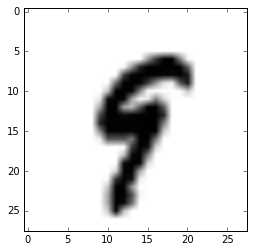

In [3]:
img_id = 903
plt.imshow(train_set[0][img_id].reshape(28,28),cmap='Greys')
print("label: " + str(train_set[1][img_id]))

Question 1: Donner les caractéristiques de la base d'apprentissage train_set

In [4]:
def getDimDataset(train_set):
    X = train_set[0]
    (n_training, n_feature) = X.shape
    n_label = len(set(train_set[1]))
    return n_training, n_feature, n_label

In [5]:
X = train_set[0]

In [10]:
n_training, n_feature, n_label = getDimDataset(train_set)

In [12]:
n_training, n_feature, n_label

(50000, 784, 10)

## Création du modèle

In [13]:
def init(n_feature,n_label):
    sigma = 1.
    W = np.random.normal(loc=0.0, scale=sigma/np.sqrt(n_feature), size=(n_label,n_feature))
    b = np.zeros((W.shape[0],1))
    return W,b

In [14]:
W,b = init(n_feature, n_label)
W.shape

(10, 784)

In [15]:
b

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

Question 2: Donner les dimensions de W et b ainsi que le nombre total de paramètres du modèle

In [16]:
def printInfo(W,b):
    print("W dimensions: " + str(W.shape))
    print("b dimensions: " + str(b.shape))
    print("Number of parameters: ", W.shape[0] * W.shape[1] + b.shape[0])
    
printInfo(W,b)

W dimensions: (10, 784)
b dimensions: (10, 1)
Number of parameters:  7850


Question 3: Implémenter la fonction forward $$z_j = \sum_{i \rightarrow N} W_{ij} x_i + b_j$$ où $x_i$ est un pixel de l'image, $W_{ij}$ est la valeur associée à l'arête reliant les unités $i$ et $j$ et $b_j$ est le bias associé à l'unité $j$

In [17]:
def forward(W,b,X):
    """
        Perform the forward propagation
        :param W: the weights
        :param b: the bias
        :param X: the input (minibatch_size x n_input)
        :type W: ndarray
        :type B: ndarray
        :type X: ndarray
        :return: the transformed values
        :rtype: ndarray (n_labels x minibatch_size)
    """
    return (np.dot(W,X.T) + b)

In [118]:
F  = forward(W,b,X)
print(F.shape, " here exemple are in column")

(10, 50000)  here exemple are in column


Question 4: Implémenter la fonction softmax $$ \sigma_i = P(t=i|x,W,b) = \frac{\exp{z_i}}{\sum_k \exp{z_k}}$$

In [120]:
def softmax(z):
    """
        Perform the softmax transformation to the pre-activation values

        :param z: the pre-activation values
        :type z: ndarray
        :return: the activation values
        :rtype: ndarray
    """
    # "axis = 0" allow to sum over the colum ! 
    return np.exp(z-np.max(z,0))/np.sum(np.exp(z-np.max(z,0)),axis = 0) 

Optionnel: Vérifier que votre implémentation de softmax soit numériquement stable (cf. http://ufldl.stanford.edu/wiki/index.php/Exercise:Softmax_Regression)

In [121]:
# Example for testing the numerical stability of softmax
# It should return [1., 0. ,0.], not [nan, 0., 0.]
z = [1000000,1,100]
print(softmax(z))

[ 1.  0.  0.]


Question 5: Implémenter le calcul du gradient de l'erreur par rapport à $z_i$:
$$\delta z_i = \sigma_i - 1_{i=l}$$
où $l$ est l'étiquette associée à la donnée courante.

In [122]:
# one exemple prediction : 
softmax(F[:,0])

array([ 0.08202463,  0.07695657,  0.1818183 ,  0.1129136 ,  0.08733916,
        0.08637511,  0.06562422,  0.08472435,  0.09434139,  0.12788266])

In [123]:
# check that the output sum to one.
softmax(F)[:,0].sum()

1.0

In [124]:
def gradient_out(out, one_hot_batch):
    """
    compute the gradient w.r.t. the pre-activation values of the softmax z_i
    :param out: the softmax values
    :type out: ndarray
    :param one_hot_batch: the one-hot representation of the labels
    :type one_hot_batch: ndarray
    :return: the gradient w.r.t. z
    :rtype: ndarray
    """
    
    derror = out - one_hot_batch
    
    return derror

In [138]:
one_hot = np.zeros((n_label,n_training))
one_hot[train_set[1],np.arange(n_training)]=1.

minibatch, one_hot_batch, minibatch_size = getMiniBatch(0, 500, train_set, one_hot)

derror = gradient_out(softmax(forward(W,b, minibatch)), one_hot_batch)
print("shape derror = ",derror.shape)
print('error is column wise')

shape derror =  (10, 500)
error is column wise


Question 6: Implémenter la fonction du calcul de gradient par rapport aux paramètres: $$\delta W_{ij} = \delta z_j x_i$$  $$\delta b_{j} = \delta z_j$$ où $\delta W_{ij}$ est la composante du gradient associée à l'arête reliant les unités $i$ et $j$, $\delta b_{j}$ est la composante du gradient associée au bias de l'unité $j$, $\delta z_j$ est le gradient de l'erreur par rapport à l'unité $j$ et $x_i$ est la valeur d'activation de l'unité $i$.

In [139]:
def gradient(derror, X):
    """
        Compute the gradient w.r.t. the parameters
        :param derror: the gradient w.r.t. z
        :param X: the input (minibatch_size x n_input)
        :param minibatch_size: the minibatch size
        :type derror: ndarray
        :type minibatch: ndarray
        :type minibatch_size: unsigned
        :return: the gradient w.r.t. the parameters
        :rtype: ndarray, ndarray
    """
    
    minibatch_size = X.shape[0]
    grad_w = derror.dot(X)/minibatch_size
    grad_b = np.sum(derror, axis = 1).reshape(-1,1)/500 
    return grad_w,grad_b

In [140]:
gradient(derror, minibatch)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[ 0.0003254 ],
        [-0.04767554],
        [ 0.03081996],
        [-0.02187259],
        [ 0.02812218],
        [ 0.01172827],
        [-0.00576441],
        [-0.00686033],
        [-0.00027843],
        [ 0.01145549]]))

Question 7: Implémenter la fonction de mise à jour des paramètres $$p = p - \eta \delta p$$ où $p$ est un paramètre du modèle et $\delta p$ la composante du gradient associée à p.

In [141]:
def update(eta, W, b, grad_w, grad_b):
    """
        Update the parameters with an update rule
        :param eta: the step-size
        :param W: the weights
        :param b: the bias
        :param grad_w: the gradient w.r.t. the weights
        :param grad_b: the gradient w.r.t. the bias
        :type eta: float
        :type W: ndarray
        :type b: ndarray
        :type grad_w: ndarray
        :type grad_b: ndarray
        :return: the updated parameters
        :rtype: ndarray, ndarray
    """
    
    
    W -= eta * grad_w
    b -= eta * grad_b
    return W,b

## Algorithme d'apprentissage

In [127]:
import math,time
from IPython.display import clear_output
from aux import *


def training(eta = .0001, n_epoch = 100, verbose = False): 
    
    # Data structures for plotting
    g_i = []
    g_train_loss=[]
    g_train_acc=[]
    g_valid_loss=[]
    g_valid_acc=[]

    n_training, n_feature, n_label = getDimDataset(train_set)

    # SGD parameters

    batch_size = 500
    n_batch = int(math.ceil(float(n_training)/batch_size))
    

    cumul_time = 0.

    # Initialize the model parameters
    W,b = init(n_feature,n_label)
    printInfo(W,b)

    # Convert the labels to one-hot vector
    one_hot = np.zeros((n_label,n_training))
    one_hot[train_set[1],np.arange(n_training)]=1.

    for i in range(n_epoch):
        for j in range(n_batch):

            ### Mini-batch creation
            minibatch, one_hot_batch, minibatch_size = getMiniBatch(j, batch_size, train_set, one_hot)

            prev_time = time.clock()

            ### Forward propagation
            Z = forward(W,b,minibatch)

            ### Compute the softmax
            out = softmax(Z)

            ### Compute the gradient at the top layer
            derror = gradient_out(out,one_hot_batch)

            ### Compute the gradient w.r.t. parameters
            grad_w,grad_b = gradient(derror, minibatch)

            ### Update the parameters
            W,b = update(eta, W, b, grad_w, grad_b)

            curr_time = time.clock()
            cumul_time += curr_time - prev_time

        ### Training accuracy
        train_loss, train_acc = computeLoss(W, b, train_set[0], train_set[1],softmax) 

        ### Valid accuracy
        valid_loss, valid_acc = computeLoss(W, b, valid_set[0], valid_set[1],softmax) 

        g_i = np.append(g_i, i)
        g_train_loss = np.append(g_train_loss, train_loss)
        g_train_acc = np.append(g_train_acc, train_acc)
        g_valid_loss = np.append(g_valid_loss, valid_loss)
        g_valid_acc = np.append(g_valid_acc, valid_acc)

        result_line = str(i) + " " + " loss:" + str(train_loss) + " acc:" + str(train_acc) + " " + str(valid_loss) + " " + str(valid_acc) + " " + str(eta)
        if verbose:
            print(result_line)
        
    return g_train_loss, g_train_acc, g_valid_loss, g_valid_acc

In [128]:
g_train_loss, g_train_acc, g_valid_loss, g_valid_acc = training(.001, 100, verbose = True)

W dimensions: (10, 784)
b dimensions: (10, 1)
Number of parameters:  7850
0  loss:2.23673151273 acc:0.1523 2.23060430998 0.1576 0.001
1  loss:2.13589476105 acc:0.2496 2.12762347469 0.2605 0.001
2  loss:2.04656607505 acc:0.36366 2.03611940098 0.3813 0.001
3  loss:1.9651554399 acc:0.4641 1.95259975288 0.4838 0.001
4  loss:1.89009770565 acc:0.53964 1.87552882055 0.5616 0.001
5  loss:1.82056316687 acc:0.59358 1.80408362834 0.6134 0.001
6  loss:1.75601340395 acc:0.63124 1.73772428447 0.6485 0.001
7  loss:1.69603274675 acc:0.65802 1.6760308216 0.6784 0.001
8  loss:1.6402626625 acc:0.67872 1.61863970802 0.6985 0.001
9  loss:1.58837666339 acc:0.6949 1.56521956393 0.7172 0.001
10  loss:1.54007121972 acc:0.7083 1.51546232176 0.7302 0.001
11  loss:1.49506278173 acc:0.71804 1.46908026274 0.743 0.001
12  loss:1.45308692401 acc:0.72744 1.42580509559 0.7525 0.001
13  loss:1.41389804425 acc:0.73632 1.38538757786 0.7628 0.001
14  loss:1.3772690374 acc:0.74334 1.34759712777 0.7695 0.001
15  loss:1.34299

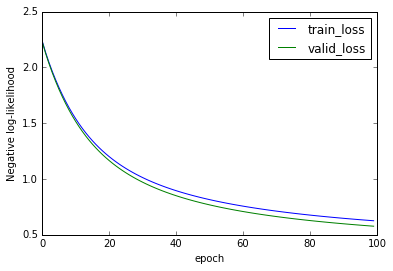

In [129]:
plt.plot(g_train_loss,label='train_loss')
plt.plot(g_valid_loss,label='valid_loss')
plt.xlabel("epoch")
plt.ylabel("Negative log-likelihood")
plt.legend()

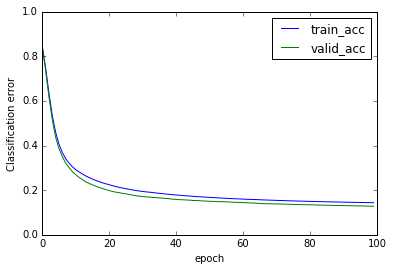

In [130]:
plt.plot(1 - g_train_acc,label='train_acc')
plt.plot(1 - g_valid_acc,label='valid_acc')
plt.xlabel("epoch")
plt.ylabel("Classification error")
plt.ylim([0.,1.])
plt.legend()

Question 8: Montrer, à l'aide d'une figure, l'effet du step-size (prendre $\eta$=[0.01,0.1,1.0,10.]) sur les courbes d'apprentissage

W dimensions: (10, 784)
b dimensions: (10, 1)
Number of parameters:  7850
W dimensions: (10, 784)
b dimensions: (10, 1)
Number of parameters:  7850
W dimensions: (10, 784)
b dimensions: (10, 1)
Number of parameters:  7850
W dimensions: (10, 784)
b dimensions: (10, 1)
Number of parameters:  7850
W dimensions: (10, 784)
b dimensions: (10, 1)
Number of parameters:  7850


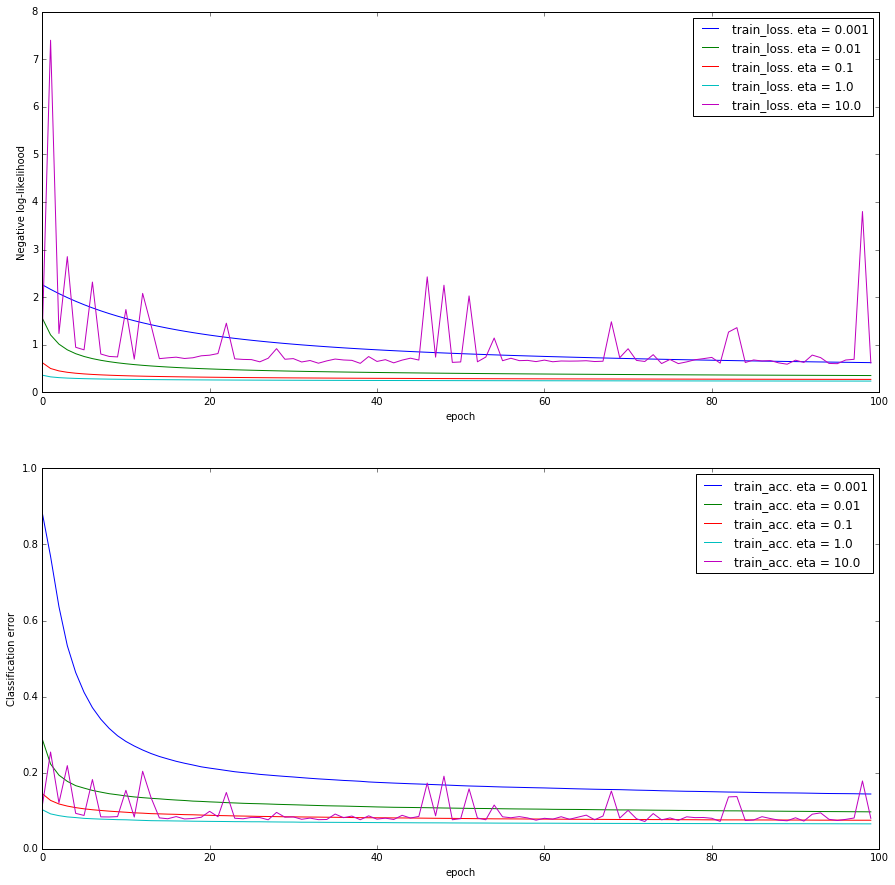

In [131]:
plt.figure(figsize = (15,15))
for eta in [.001,0.01,0.1,1.0,10.]:
    g_train_loss, g_train_acc, g_valid_loss, g_valid_acc = training(eta, 100)
    
    plt.subplot(211)
    plt.plot(g_train_loss,label='train_loss. eta = ' +str(eta))
    #plt.plot(g_i,g_valid_loss,label='valid_loss. eta = ' +str(eta))
    plt.xlabel("epoch")
    plt.ylabel("Negative log-likelihood")
    plt.legend()
    
    plt.subplot(212)
    
    plt.plot(1- g_train_acc,label='train_acc. eta = ' +str(eta))
    #plt.plot(g_i,1- g_valid_acc,label='valid_acc. eta = ' +str(eta))
    plt.xlabel("epoch")
    plt.ylabel("Classification error")
    plt.ylim([0.,1.])
    plt.legend()

W dimensions: (10, 784)
b dimensions: (10, 1)
Number of parameters:  7850
W dimensions: (10, 784)
b dimensions: (10, 1)
Number of parameters:  7850
W dimensions: (10, 784)
b dimensions: (10, 1)
Number of parameters:  7850
W dimensions: (10, 784)
b dimensions: (10, 1)
Number of parameters:  7850
W dimensions: (10, 784)
b dimensions: (10, 1)
Number of parameters:  7850


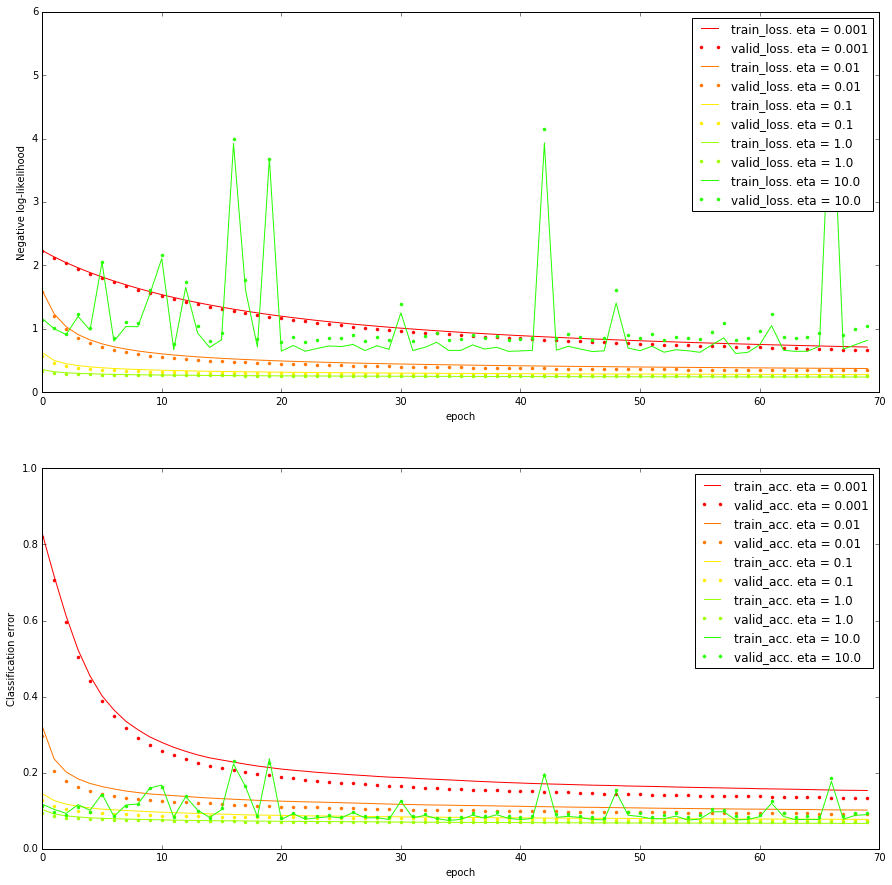

In [160]:
plt.figure(figsize = (15,15))
for ii,eta in enumerate([.001,0.01,0.1,1.0,10.]):
    g_train_loss, g_train_acc, g_valid_loss, g_valid_acc = training(eta, 70)
    
    plt.subplot(211)
    plt.plot(g_train_loss,label='train_loss. eta = ' +str(eta), c = plt.get_cmap('hsv')(ii*20))
    plt.plot(g_valid_loss,'.',label='valid_loss. eta = ' +str(eta), c = plt.get_cmap('hsv')(ii*20))
    plt.xlabel("epoch")
    plt.ylabel("Negative log-likelihood")
    plt.legend()
    
    plt.subplot(212)
    
    plt.plot(1- g_train_acc,label='train_acc. eta = ' +str(eta), c = plt.get_cmap('hsv')(ii*20))
    plt.plot(1- g_valid_acc,'.',label='valid_acc. eta = ' +str(eta), c = plt.get_cmap('hsv')(ii*20))
    plt.xlabel("epoch")
    plt.ylabel("Classification error")
    plt.ylim([0.,1.])
    plt.legend()